In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
# blocks output in Colab 💄
%%capture

! pip install datasets transformers

## Load a dataset

In [ ]:
from datasets import load_dataset, load_metric
from transformers import BeitFeatureExtractor, BeitForImageClassification
from transformers import TrainingArguments
import torch
import numpy as np
from transformers import Trainer
import pandas as pd
from PIL import Image



# ds = load_dataset('/content/gdrive/MyDrive/range_time_jpg')
# ds

## Loading ViT Feature Extractor

In [ ]:
model_name_or_path = 'microsoft/beit-base-patch16-224-pt22k-ft22k'
feature_extractor = BeitFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.9/dist-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(


## Processing the Dataset

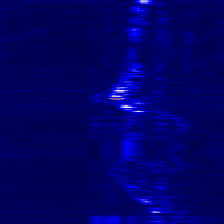

In [ ]:
# from PIL import Image, ImageFilter

# # define function for image preprocessing
# def preprocess_image2(img_path):
#     # open image with PIL
#     img = Image.open(img_path)
    
#     # resize image to 224x224
#     img = img.resize((224, 224))
    
#     # apply edge detection
#     img = img.filter(ImageFilter.DETAIL)
    
#     # convert image to grayscale
#     # img = img.convert('RGB')
    
#     # # normalize pixel values to range [0, 1]
#     # img = img.point(lambda x: x / 255)
    
#     return img

# # example usage
# img_path = '/content/gdrive/MyDrive/range_time_seismic/0/075830c4-30ef-42fa-81e6-6441ac3a0316.jpg'
# preprocessed_img = preprocess_image2(img_path)
# preprocessed_img


In [ ]:
# # define function for image preprocessing
# def preprocess_image(img):
#     # open image with PIL
#     # img = Image.open(img_path)
#     img = img['image']
#     # resize image to 224x224
#     img = img.resize((224, 224))
    
#     # apply edge detection
#     img = img.filter(ImageFilter.DETAIL)
    
#     # convert image to grayscale
#     # img = img.convert('L')
    
#     # # normalize pixel values to range [0, 1]
#     # img = img.point(lambda x: x / 255)
    
#     return img

In [ ]:
! mkdir /content/gdrive/MyDrive/train_signal_x1
! mkdir /content/gdrive/MyDrive/train_signal_x1/0
! mkdir /content/gdrive/MyDrive/train_signal_x1/1
! mkdir /content/gdrive/MyDrive/train_signal_x1/2
! mkdir /content/gdrive/MyDrive/train_signal_x1/3
! mkdir /content/gdrive/MyDrive/train_signal_x1/4
! mkdir /content/gdrive/MyDrive/train_signal_x1/5
! mkdir /content/gdrive/MyDrive/train_signal_x1/6

In [ ]:
ds = load_dataset('/content/gdrive/MyDrive/trainset_time_denoise_hot')
# The full `train` split and the full `test` split as two distinct datasets.
def transform(example_batch):
    
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

# prepared_ds = ds.with_transform(transform)

Resolving data files:   0%|          | 0/646 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/trainset_time_denoise_hot-47922d5bf15dcf43/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

We can directly apply this to our dataset using `ds.with_transform(transform)`.

In [ ]:
prepared_ds = ds.with_transform(transform)

In [ ]:
prepared_ds = prepared_ds["train"].train_test_split(test_size=0.2)

# Training and Evaluation


### Define our data collator

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### Define an evaluation metric


In [ ]:
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [ ]:
labels = ds['train'].features['label'].names

model = BeitForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)} , ignore_mismatched_sizes=True
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--beit-base-patch16-224-pt22k-ft22k/snapshots/9da301148150e37e533abef672062fa49f6bda4f/config.json
Model config BeitConfig {
  "architectures": [
    "BeitForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "auxiliary_channels": 256,
  "auxiliary_concat_input": false,
  "auxiliary_loss_weight": 0.4,
  "auxiliary_num_convs": 1,
  "drop_path_rate": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "0",
    "1": "1",
    "2": "2",
    "3": "3",
    "4": "4",
    "5": "5",
    "6": "6"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "0": "0",
    "1": "1",
    "2": "2",
    "3": "3",
    "4": "4",
    "5": "5",
    "6": "6"
  },
  "layer_norm_eps": 1e-12,
  "layer_scale_init_value": 0.1,
  "model_type": "beit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "n

In [ ]:
! mkdir /content/test1

In [ ]:
training_args = TrainingArguments(
  output_dir="./test1",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=15,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-5,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

PyTorch: setting up devices


Now, all instances can be passed to Trainer and we are ready to start training!



In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 516
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 495
  Number of trainable parameters = 85767367


Step,Training Loss,Validation Loss,Accuracy
100,0.176500,0.764862,0.761538
200,0.057900,0.869947,0.769231
300,0.012000,1.026407,0.784615
400,0.001400,1.165118,0.792308


***** Running Evaluation *****
  Num examples = 130
  Batch size = 8
Saving model checkpoint to ./test1/checkpoint-100
Configuration saved in ./test1/checkpoint-100/config.json
Model weights saved in ./test1/checkpoint-100/pytorch_model.bin
Image processor saved in ./test1/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 130
  Batch size = 8
Saving model checkpoint to ./test1/checkpoint-200
Configuration saved in ./test1/checkpoint-200/config.json
Model weights saved in ./test1/checkpoint-200/pytorch_model.bin
Image processor saved in ./test1/checkpoint-200/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 130
  Batch size = 8
Saving model checkpoint to ./test1/checkpoint-300
Configuration saved in ./test1/checkpoint-300/config.json
Model weights saved in ./test1/checkpoint-300/pytorch_model.bin
Image processor saved in ./test1/checkpoint-300/preprocessor_config.json
Deleting older checkpoint [test1/checkpoint-200] due to ar

***** train metrics *****
  epoch                    =        15.0
  total_flos               = 558382386GF
  train_loss               =       0.088
  train_runtime            =  0:03:39.38
  train_samples_per_second =      35.281
  train_steps_per_second   =       2.256


In [ ]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 130
  Batch size = 8


***** eval metrics *****
  epoch                   =       15.0
  eval_accuracy           =     0.7615
  eval_loss               =     0.7649
  eval_runtime            = 0:00:01.85
  eval_samples_per_second =     70.089
  eval_steps_per_second   =      9.166


In [ ]:

submid_df = pd.read_csv("/content/sample_submission (1).csv")
submid_df

,id,class
0,30de3513-93ff-42d8-ad5f-4c93f4a4444c,6.0
1,84e55af1-ae63-4b06-b650-1136d38b691e,4.0
2,2471a7eb-af35-4ae7-870e-6650de9f0c2f,2.0
3,d00e8bdc-79af-4e55-b25a-96ea589b6420,NaN
4,ad9f77bc-5ab6-477d-b760-2f3fc65c14d3,NaN
...,...,...
159,5fce955d-1068-40b3-afc3-111f8c22c9f9,NaN
160,f3a000be-07c9-44ad-8ff0-b89a9a1070dd,NaN
161,84d3963b-cfed-450c-88ab-ca853273d15c,NaN
162,7b36184c-5541-44d9-9200-8057bd3cf4ef,NaN


## **Predict**

In [ ]:

pred = []
for i in submid_df["id"]:
  img = Image.open("/content/gdrive/MyDrive/testset_time_denoise_hot/{}.jpg".format(i))
  img = feature_extractor(img, return_tensors='pt').to('cuda')


  with torch.no_grad():
      logits = model(**img).logits

  # model predicts one of the 1000 ImageNet classes
  predicted_label = logits.argmax(-1).item()
  pred.append(predicted_label)

In [ ]:
submid_df["class"] = pred
submid_df.to_csv("submit_ep32_b16_hot_eval_ 0.7615_beit.csv", index =False)

In [ ]:
submid_df

,id,class
0,30de3513-93ff-42d8-ad5f-4c93f4a4444c,3
1,84e55af1-ae63-4b06-b650-1136d38b691e,5
2,2471a7eb-af35-4ae7-870e-6650de9f0c2f,4
3,d00e8bdc-79af-4e55-b25a-96ea589b6420,4
4,ad9f77bc-5ab6-477d-b760-2f3fc65c14d3,0
...,...,...
159,5fce955d-1068-40b3-afc3-111f8c22c9f9,3
160,f3a000be-07c9-44ad-8ff0-b89a9a1070dd,4
161,84d3963b-cfed-450c-88ab-ca853273d15c,1
162,7b36184c-5541-44d9-9200-8057bd3cf4ef,6
